# Machine Learning 2
## Classification task
### Tomasz Starakiewicz
### 28.02.2023

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics

import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

### Data

The dataset contains used cars listings scraped from the internet (specific website is unknown, but we know these are UK listing), which have been published in 2020 on Kaggle under the link below:
https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes

### Problem
The goal is to build an predictive model for the Audi brand. This can then be used in two ways:
- to price own car one is about to sell on the secondary market, to avoid underpricing
- to identify bargains, when new offers are scraped and price with the models - when actual price diverges from the expected price, this might indiciate the owner has underpriced their car (but might also mean simply that the car has a hidden flaw we are not aware of and are not able to model)


In [90]:
df = pd.read_csv('../data/diabetes_BRFSS2015.csv').groupby('Diabetes_binary').sample(n=15000, random_state=123)
print('Observations:', len(df))
print('NAs in target variable:', df['Diabetes_binary'].isna().sum())

Observations: 30000
NAs in target variable: 0


The dataset contains 10k observations, all with a proper target variable.

### Data partitioning

We partition the data before EDA, to ensure no bias finds its way into the model building.

In [91]:
train, test = train_test_split(df, test_size=0.2, random_state=123)
X_train = train.drop(columns='Diabetes_binary')
y_train = train['Diabetes_binary']

X_test = test.drop(columns='Diabetes_binary')
y_test = test['Diabetes_binary']

### Exploratory Data Analysis

There appear to be 5 numerical features:
- interval: year
- ratio: mileage, tax, mpg, engineSize

However, we need to verify if some of them are not better treated as ordinal variables with low cardinality, e.g. engineSize, since they are likely to have only a few distinct values.

In [92]:
num_vars = ['BMI', 'PhysHlth', 'MentHlth']
bin_vars = [
    'HighBP', 'HighChol', 'CholCheck', 'Stroke', 'Smoker', 'HeartDiseaseorAttack',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
    'DiffWalk', 'Sex',
]
ord_vars = ['Education', 'GenHlth', 'Income', 'Age']

In [93]:
display(X_train[num_vars].describe())

,BMI,PhysHlth,MentHlth
count,24000.000000,24000.000000,24000.000000
mean,29.848083,5.785375,3.800500
std,7.138041,10.023693,8.197032
min,13.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000
50%,29.000000,0.000000,0.000000
75%,33.000000,6.000000,2.000000
max,98.000000,30.000000,30.000000


In [94]:
display(X_train[bin_vars].describe())

,HighBP,HighChol,CholCheck,Stroke,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,0.571375,0.526208,0.974292,0.062542,0.468542,0.146875,0.705208,0.611583,0.786083,0.042417,0.954708,0.093208,0.251375,0.455958
std,0.494890,0.499323,0.158267,0.242142,0.499020,0.353989,0.455959,0.487400,0.410077,0.201542,0.207947,0.290730,0.433813,0.498067
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


All of the variables represent some degree of skewness and outliers, so for some models variable transformations will be necessary.

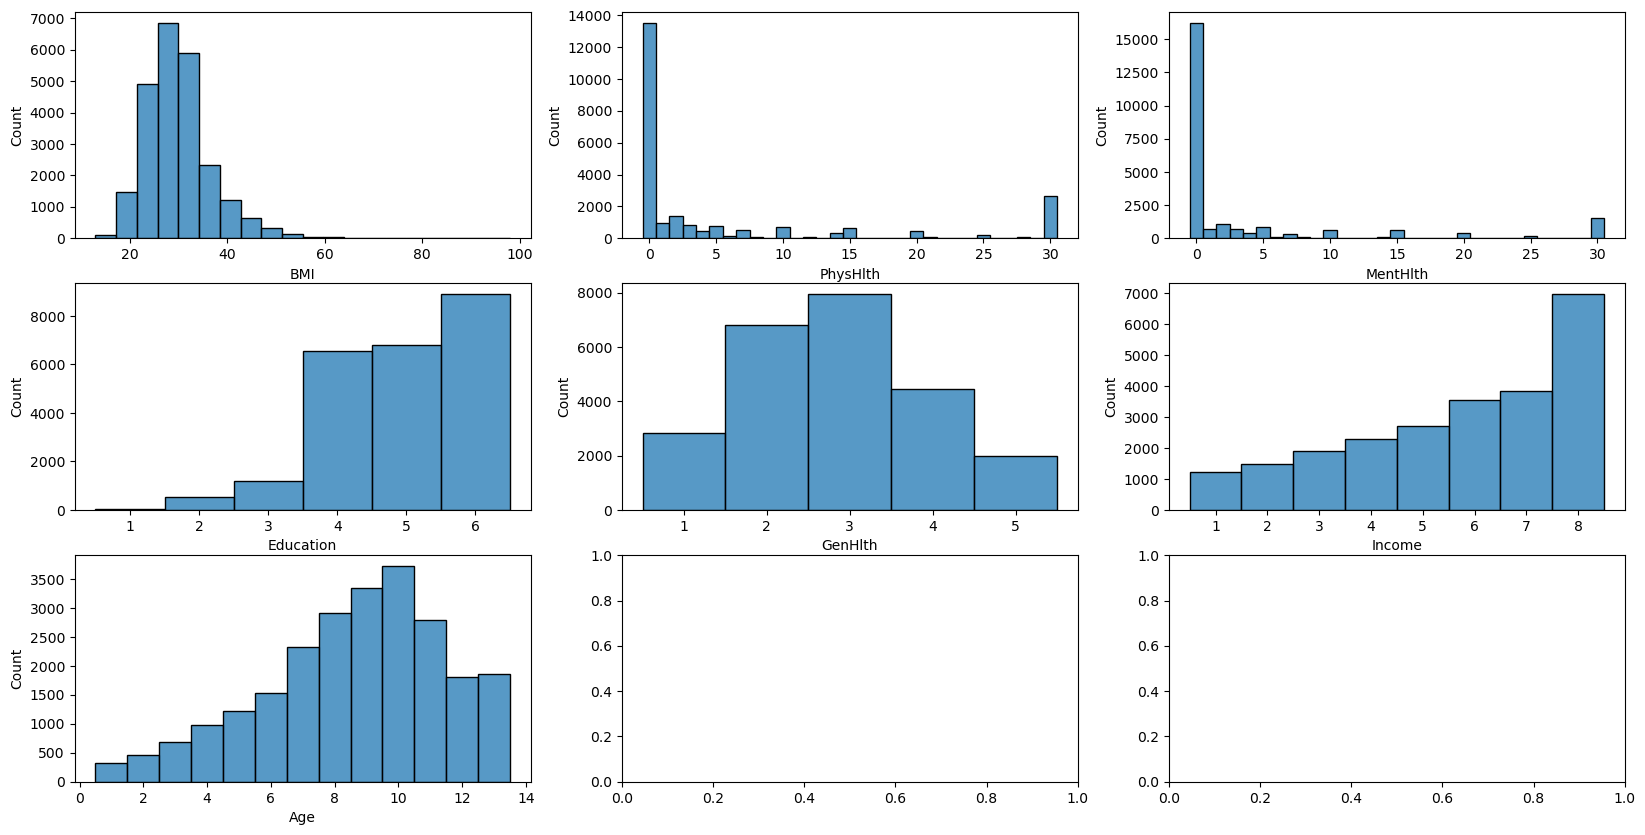

In [95]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))

sns.histplot(X_train[num_vars[0]], bins=20, ax=axs[0][0])
sns.histplot(X_train[num_vars[1]], discrete=True, ax=axs[0][1])
sns.histplot(X_train[num_vars[2]], discrete=True, ax=axs[0][2])
sns.histplot(X_train[ord_vars[0]], discrete=True, ax=axs[1][0])
sns.histplot(X_train[ord_vars[1]], discrete=True, ax=axs[1][1])
sns.histplot(X_train[ord_vars[2]], discrete=True, ax=axs[1][2])
sns.histplot(X_train[ord_vars[3]], discrete=True, ax=axs[2][0])
plt.show()

In the bottom row, we see, unsuprisingly, that:
- year (of production) is positively correlated with the price
- mileage is negatively correlated with the price
- engine size is positively correlated with the price

What is more surprising:
- mpg (fuel efficiency) is negatively correlated with the price, though this might be due to the fact that mpg is negatively correlated with engine size and milage, i.e. newer, stronger cars with lower mpg are more expensive

All of these display low to mdeium level of non-linearity around extreme values

Aside from that, we see that:
- mileage and production year are negatively correlated, as expected, so we'll need to be catious at feature selection stage

/Users/tjstarak/miniconda3/envs/ml2/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/tjstarak/miniconda3/envs/ml2/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


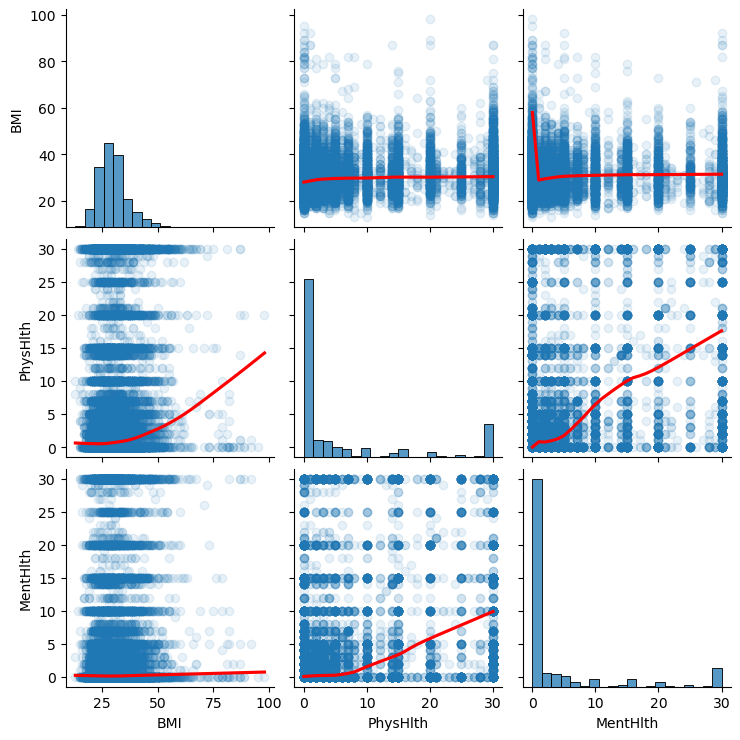

In [98]:
sns.pairplot(
    X_train[num_vars], kind='reg',
    plot_kws={'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.1}, 'ci': None, 'lowess': True},
    diag_kws={'bins': 20}
)
plt.show()

Categorical variables seem informative at first glance, e.g. automatic cars are positively associated with price, though there is not much difference between petrol and diesel cars in terms of price. Unsuprisingly the prices vary greatly across model types.

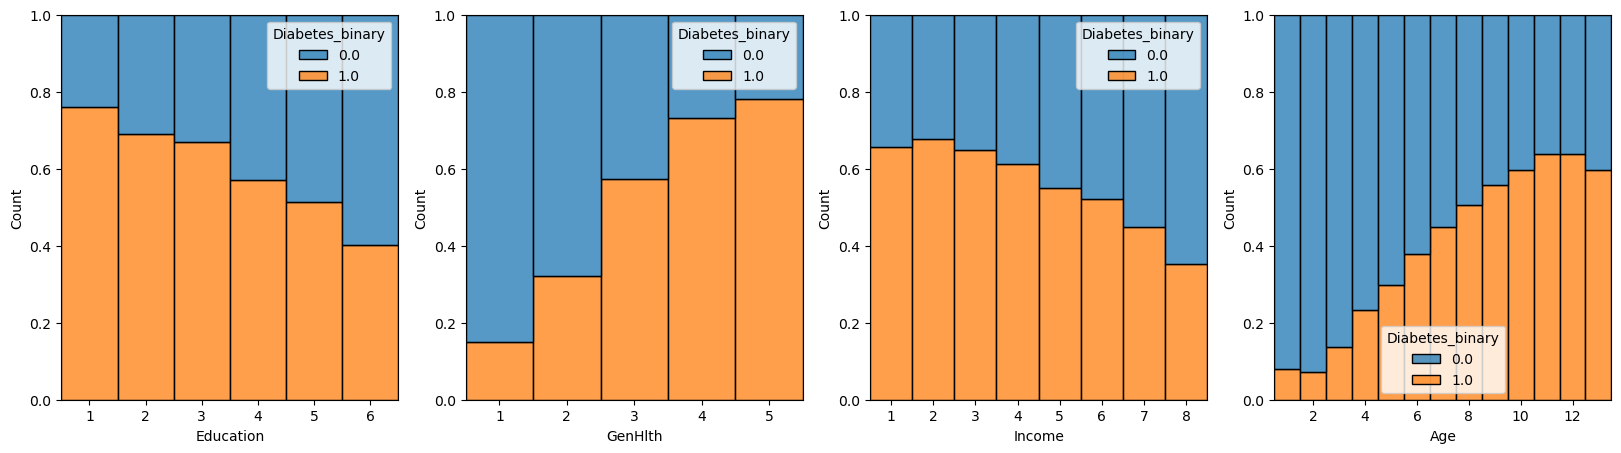

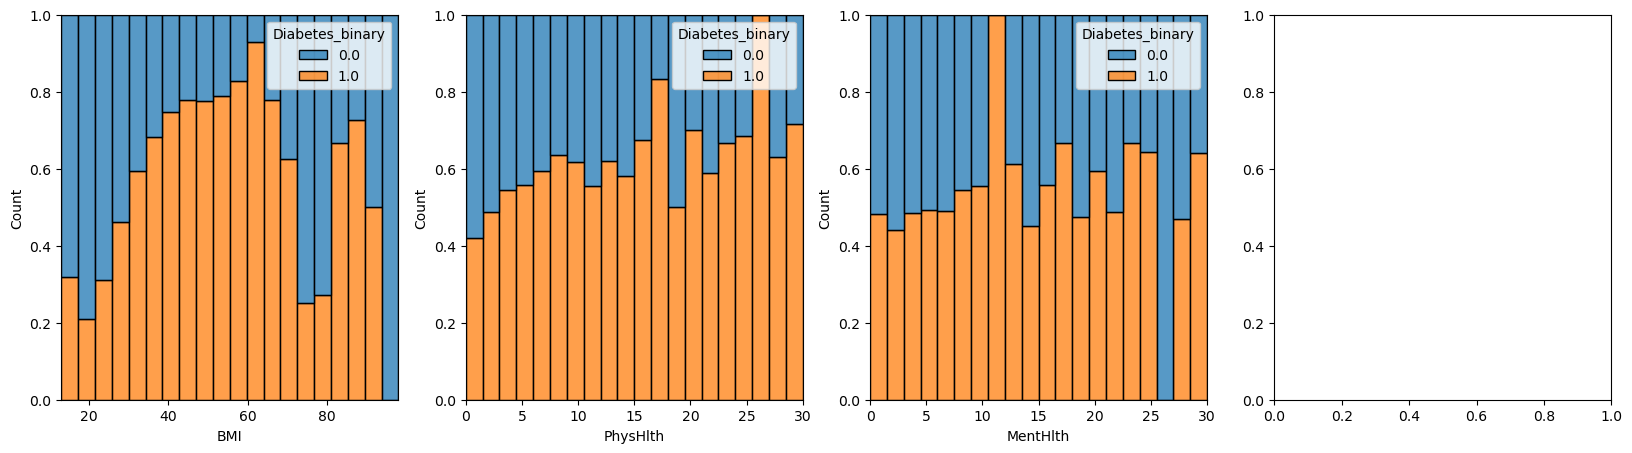

In [97]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
for var, ax in zip(ord_vars, axs):
    sns.histplot(data=pd.concat([X_train, y_train], axis=1), x=var, hue='Diabetes_binary', discrete=True, multiple='fill', ax=ax)
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(20,5))
for var, ax in zip(num_vars, axs):
    sns.histplot(data=pd.concat([X_train, y_train], axis=1), x=var, hue='Diabetes_binary', bins=20, multiple='fill', ax=ax)
plt.show()

### Variable transformation


To stabilize variance and minimize skewness, we will apply Yeo-Johnson transform (since Box-Cox applies only to strictly positive data), the optimal scaling factor will be identified via maximum likelihood estimation.

To get a correct estimate of performance, we need to determine transformation parameters for each split separately, so at this point we only define the PowerTransformer, to be put later in the pipeline.

We will not transform variables for decision-tree based models, Random Forest and XGBoost, since they can model non-linearity naturally.

There are no missing values, so we don't need to impute.

In [99]:
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

We will one hot encode categorical variables.

We will group infrequent car models into 'other'. Theoretically this should be also done in a pipeline, so in this case the cross-validation score will be biased, but the impact, if any, is minimal. At the same time, this will make it easier to use native XGBoost API, which makes it much easier to use early-stopping with cross-validation.

We build the Top 10 list exclusively on the training data, so the test scores will not be impacted.

#### Variable selection


Mileage and year have substantial correlation (-0.79), likewise mpg and tax, though only at moderate level (-0.63).

In [100]:
corr = X_train[num_vars+ord_vars].corr(numeric_only=True, method='kendall')
corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,BMI,PhysHlth,MentHlth,Education,GenHlth,Income,Age
BMI,1.00,0.12,0.06,-0.10,0.21,-0.09,-0.03
PhysHlth,0.12,1.00,0.30,-0.12,0.45,-0.20,0.04
MentHlth,0.06,0.30,1.00,-0.05,0.23,-0.14,-0.13
Education,-0.10,-0.12,-0.05,1.00,-0.24,0.38,-0.08
GenHlth,0.21,0.45,0.23,-0.24,1.00,-0.31,0.11
Income,-0.09,-0.20,-0.14,0.38,-0.31,1.00,-0.13
Age,-0.03,0.04,-0.13,-0.08,0.11,-0.13,1.00


#### Cross-validation

For hyperparameter tuning, we will use 5-fold cross validation.

In [101]:
log_reg_transformer = make_column_transformer(
    (power_transformer, num_vars+ord_vars),
    # (make_pipeline(StandardScaler(), power_transformer), ['year']),
    # (OneHotEncoder(), ['model', 'transmission', 'fuelType']),
    remainder='passthrough'
)

log_reg = make_pipeline(log_reg_transformer, LogisticRegression())
display(log_reg)

log_reg_cv_results = cross_validate(
    log_reg, X_train, y_train, 
    scoring=['roc_auc', 'f1'],
    cv=5
)

display(pd.DataFrame(log_reg_cv_results).agg('mean'))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('powertransformer',
                                                  PowerTransformer(),
                                                  ['BMI', 'PhysHlth',
                                                   'MentHlth', 'Education',
                                                   'GenHlth', 'Income',
                                                   'Age'])])),
                ('logisticregression', LogisticRegression())])

fit_time        0.084500
score_time      0.006852
test_roc_auc    0.822900
test_f1         0.749151
dtype: float64

In [181]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', low=10, high=100, step=5),
        'max_depth': trial.suggest_int('max_depth', low=5, high=20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', low=1, high=10),
        'min_samples_split': trial.suggest_int('min_samples_split', low=1, high=10),
        'max_features': trial.suggest_float('max_features', low=0.7, high=1.0, step=0.05),
    }

    rf_clf = make_pipeline(RandomForestClassifier(**params))

    rf_clf_cv_results = cross_validate(
        rf_clf, X_train, y_train,
        scoring='roc_auc',
        cv=5
    )

    score = rf_clf_cv_results['test_score'].mean()

    return score

study = optuna.create_study(sampler=TPESampler(seed=123), direction='maximize')
study.optimize(objective, n_trials=50)

cols = ['Iteration number', 'Score'] + list(study.best_params.keys())
results = [study.best_trial.number, study.best_trial.value] + list(study.best_params.values())
results_df = pd.DataFrame([results], columns = cols)
display(results_df)

,Iteration number,Score,n_estimators,max_depth,min_samples_leaf,min_samples_split,max_features
0,17,0.821272,115,8,3,9,0.7


In [182]:
rf_params = {
    'n_estimators': 100,
    'max_depth': 8,
    'min_samples_leaf': 1,
    'min_samples_split': 8,
    'max_features': 0.7,
}

rf_clf = make_pipeline(RandomForestClassifier(**rf_params))
display(rf_clf)

rf_clf_cv_results = cross_validate(
    rf_clf, X_train, y_train,
    scoring=['roc_auc', 'f1'],
    cv=5
)

pd.DataFrame(rf_clf_cv_results).agg('mean')

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=8, max_features=0.7,
                                        min_samples_leaf=3, min_samples_split=9,
                                        n_estimators=115))])

fit_time        1.554920
score_time      0.084596
test_roc_auc    0.821297
test_f1         0.756229
dtype: float64

In [120]:
dtrain = xgb.DMatrix(X_train, y_train)

In [126]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):

    params = {
        'objective': 'binary:logistic',
        'eta': 0.3,
        'max_depth': trial.suggest_int('max_depth', low=4, high=10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', low=0.6, high=1, step=0.1),
        'subsample': trial.suggest_float('subsample', low=0.6, high=1, step=0.1),
        'alpha': trial.suggest_float('alpha', low=0, high=0.3, step=0.05),
        'eval_metric': 'auc',
    }

    result = xgb.cv(params, dtrain, num_boost_round=100, early_stopping_rounds=5, nfold=5, seed=123)
    score = result['test-auc-mean'].iloc[-1]
    score

    return score

study = optuna.create_study(sampler=TPESampler(seed=123), direction='maximize')
study.optimize(objective, n_trials=50)

cols = ['Iteration number', 'Score'] + list(study.best_params.keys())
results = [study.best_trial.number, study.best_trial.value] + list(study.best_params.values())
results_df = pd.DataFrame([results], columns = cols)
display(results_df)

,Iteration number,Score,max_depth,colsample_bytree,subsample,alpha
0,24,0.825804,4,0.6,0.8,0.25


In [142]:
xgb_params = {
    'objective': 'binary:logistic',
    'eta': 0.1,
    'max_depth': 4,
    'colsample_bytree': 0.6,
    'subsample': 0.8,
    'alpha': 0.25,
    'eval_metric': 'auc',
}

results = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=10, nfold=5, seed=123)

print('Boosting rounds:', len(results))
print('Best AUC:', results['test-auc-mean'].iloc[-1])

Boosting rounds: 66
Best AUC: 0.8268508524816106


In [147]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    f1 = metrics.f1_score(y_true, np.round(y_pred))
    return 'f1', f1

results = xgb.cv(xgb_params, dtrain, custom_metric=f1_eval, num_boost_round=66, nfold=5, seed=123)
print('AUC:', results['test-auc-mean'].iloc[-1])
print('f1:', results['test-f1-mean'].iloc[-1])

AUC: 0.8268508524816106
f1: 0.7601262


#### Model assessment and comparison

In [161]:
def print_performance_summary(y_true, y_pred):
    print(f'AUC: {metrics.roc_auc_score(y_true, y_pred):.4f}')
    print(f'f1: {metrics.f1_score(y_true, (y_pred>0.5)*1):.4f}')

In [162]:
log_reg.fit(X_train, y_train)
log_pred = log_reg.predict_proba(X_test)[:,1]

print_performance_summary(y_test, log_pred)

AUC: 0.8258
f1: 0.7557


In [183]:
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict_proba(X_test)[:,1]

print_performance_summary(y_test, rf_pred)

AUC: 0.8263
f1: 0.7597


In [180]:
xgb_clf = xgb.train(xgb_params, dtrain)
dtest = xgb.DMatrix(X_test)
y_pred = xgb_clf.predict(dtest)

print_performance_summary(y_test, y_pred)

AUC: 0.8192
f1: 0.7561


#### Summary